In [1]:
#Importing Keras packages
from __future__ import print_function
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.layers.advanced_activations import ELU, LeakyReLU, PReLU, Softmax, ReLU
from keras.regularizers import l2
from tensorflow.keras import initializers
import pandas as pd
import numpy as np

Using TensorFlow backend.


(50000, 1)
(10000, 1)
(50000, 32, 32, 3)
(10000, 32, 32, 3)


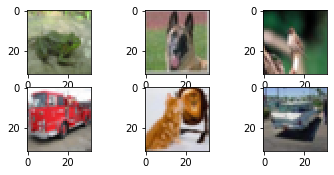

(50000, 32, 32, 3)
(10000, 32, 32, 3)
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [2]:
#Loading the CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(y_train.shape)
print(y_test.shape)
print(x_train.shape)
print(x_test.shape)

#Data Pre-processing and Inspection
img_rows = x_train[0].shape[0]
img_cols = x_train[1].shape[0]

#Inspection
import matplotlib.pyplot as plt

#Plotting 6 images with color map set to grey since the images are greyscale
plt.subplot(331)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(332)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(333)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(334)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(335)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))

plt.subplot(336)
random_num = np.random.randint(0,len(x_train))
plt.imshow(x_train[random_num], cmap = plt.get_cmap('gray'))
plt.show()

#Normalise the data by changing the range from (0 to 255) to (0 to 1)
x_train =  x_train/255
x_test = x_test/255
print(x_train.shape)
print(x_test.shape)

#Change the image type to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [3]:
from tensorflow.keras.utils import to_categorical

#One-hot encode the outputs
y_cat_train = to_categorical(y_train,10)
y_cat_test = to_categorical(y_test,10)

print("Number of Classes: " + str(y_test.shape[1]))

num_classes = y_test.shape[1]
num_pixels = x_train.shape[1] * x_train.shape[2]
print("Number of Pixels: " + str(num_pixels)) #32*32=1024

y_train.shape
y_train[0]

Number of Classes: 1
Number of Pixels: 1024


array([6], dtype=uint8)

In [4]:
#Setting up some of the hyperparameters
batch_size = 64
num_classes = 10
epochs = 10
input_shape = x_train.shape[1:]

In [5]:
#Ensuring the model is built on the existing GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
physical_devices------------- 1


In [6]:
from keras.applications import VGG16

img_rows = 32
img_cols = 32 

#Loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape)

for layer in vgg16.layers:
    layer.trainable = False

for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [7]:
#Building ontop of the freezed layers
def addTopModel(bottom_model, num_classes, D = 512):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "elu")(top_model)
    top_model = Dense(10, activation = "softmax")(top_model)
    return top_model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 10

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs = vgg16.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [9]:
#Model testing and reporting
opt = keras.optimizers.Adam(lr = 0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

history = model.fit(x_train, y_cat_train, batch_size = batch_size, 
                    epochs = epochs, validation_data = (x_test, y_cat_test), shuffle = True)

#Saving model weights
model.save("C:\\Users\\Admin\\Desktop\\Research\\Results\\VGGNet Results\\Weights\\CIFAR_VGGNet_ELU_Adam_Weights.h5")

#Evaluate the performance of the trained model
scores = model.evaluate(x_test, y_cat_test, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 200us/step - loss: 1.3432 - accuracy: 0.5306 - val_loss: 1.2709 - val_accuracy: 0.5505
Epoch 2/10
50000/50000 [==============================] - 7s 147us/step - loss: 1.2032 - accuracy: 0.5796 - val_loss: 1.2217 - val_accuracy: 0.5770
Epoch 3/10
50000/50000 [==============================] - 7s 147us/step - loss: 1.1642 - accuracy: 0.5920 - val_loss: 1.2241 - val_accuracy: 0.5741
Epoch 4/10
50000/50000 [==============================] - 7s 149us/step - loss: 1.1370 - accuracy: 0.6026 - val_loss: 1.2141 - val_accuracy: 0.5776
Epoch 5/10
50000/50000 [==============================] - 7s 149us/step - loss: 1.1066 - accuracy: 0.6136 - val_loss: 1.1948 - val_accuracy: 0.5835
Epoch 6/10
50000/50000 [==============================] - 7s 149us/step - loss: 1.0839 - accuracy: 0.6229 - val_loss: 1.1553 - val_accuracy: 0.5945
Epoch 7/10
50000/50000 [==============================] - 7s 

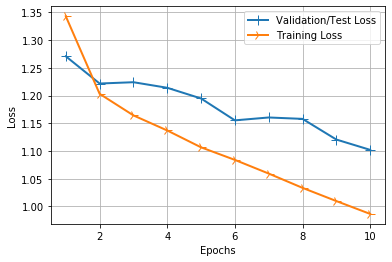

In [10]:
#Evaluating training and test error
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()